# Creating and Visualizing a Scene with Geo2SigMap

The [Geo2SigMap](https://github.com/functions-lab/geo2sigmap) package is a powerful new package developed by [Tingjun Chen's lab](https://functions-lab.github.io/) at Duke University that enables users to generate 3D models for arbitary geographic regions.  These 3D models can be directly used by Sionna.  I am starting to create some custom scenes from the package that we can use in the class.  In this demo, you will learn to:

* Load a custom scene from the `sionnautils` package.
* Save meta data of the area
* Plot the area
* Locate a street address or (lat, long) in the x-y area using a coordinate transformation
* Generate your own scene and meta information using an API from `sionnautils`.

Thanks to the amazing PhD student, Mingyun Ying, for helping with coordinate transformations.


## Importing Sionna
We next import sionna and sionnautils package as usual.

In [2]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

We also import the sionnautils package from the wireless class

In [3]:
# Import Sionna utils from the wireless class
try:
    import sionnautils
except ImportError as e:
    # Install Sionna if package is not already installed
    !pip install git+https://github.com/sdrangan/wirelesscomm.git
    import sionnautils

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

## Loading and Visualizing a Pre-Generated Custom Scene

For the class, I will create custom scenes using the geo2sigmap package.  You can list the scenes available with the following command.  Right now, you should only see two scenes:  `'nyu_tandon'` which is a 1km x 1km area around our campus is Brooklyn, NY.  There is also an `'empty_scene'`.  But, I may add more.




In [13]:
from sionnautils.custom_scene import list_scenes, get_scene
scenes = list_scenes()
print(scenes)

['empty_scene', 'nyu_tandon']


We can get one of the pre-generated scenes as follows.  The `map_data` dictionary has the meta data of the scene.

In [14]:
scene_path, map_data = get_scene('nyu_tandon')
for k, v in map_data.items():
    print(f'{k}: {v}')

bbox_lat: [40.69012764197041, 40.699120858029595]
bbox_long: [-73.99156687083165, -73.97970552916836]
address: 5 MetroTech Center, Brooklyn, NY 11201
descr: NYU Tandon campus


We can then visualize the scene as follows.

In [21]:
scene = sionna.rt.load_scene(scene_path)
# Render scene
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=512);

In [22]:
%%skip_if no_preview
# Open 3D preview (only works in Jupyter notebook)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [16]:
import os
nyu_tandon_scene = os.path.join(os.getcwd(), 'nyu_tandon\\scene.xml')
print(nyu_tandon_scene)
os.path.exists(nyu_tandon_scene)

scene = sionna.rt.load_scene(nyu_tandon_scene)

C:\Users\sdran\Dropbox\srangan\academic\courses\Wireless\wirelesscomm\docs\geodemo\nyu_tandon\scene.xml


In [17]:
# Render scene
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=512);

In [18]:
%%skip_if no_preview
# Open 3D preview (only works in Jupyter notebook)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Extracting the Buildings

We next use the sionnautils package to extract the buildings.

In [23]:
from sionnautils.miutils import CoverageMapPlanner

grid_size = 5

cm = CoverageMapPlanner(scene._scene, grid_size=grid_size)
cm.set_grid()
cm.compute_grid_attributes()

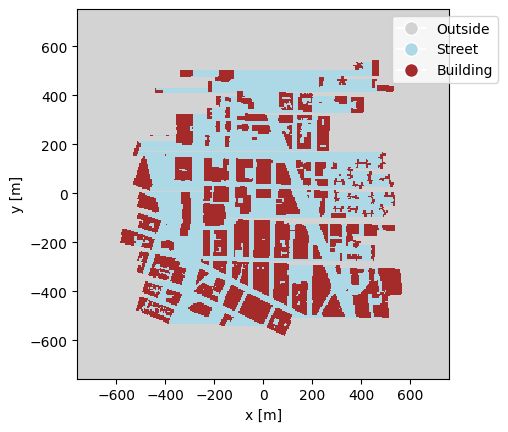

In [24]:
# Define a custom color map with RGB values
from matplotlib.colors import ListedColormap
colors = ['lightgray', 'lightblue', 'brown']
cmap = ListedColormap(colors)


#  Create a grid of point types
outdoor = (cm.bldg_grid==False) & cm.in_region
building = (cm.bldg_grid) & cm.in_region
point_type = outdoor + 2*building
point_type = point_type.astype(int)
point_type = np.flipud(point_type)

# Plot the grid
extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)

# Create a legend
legend_labels = ['Outside', 'Street', 'Building']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))

# Add titles and labels
_ = plt.xlabel('x [m]')
_ = plt.ylabel('y [m]')

## Highlight a Street Address with Given Lat-Long Coordinates

Often you have points in (lat, long) coordinates that you want to place in the coverage area.  

First, we can find a location, for example, with the `geopy` package.  You can also directly find the lat-long from Google maps.  In this case, the adderss is one of NYU's engineering buildings (where my office is in case you want to visit).

In [25]:
from geopy.geocoders import Nominatim

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="wireless_class")

# Address to get coordinates for
#address = "5 MetroTech Center, Brooklyn, NY 11201"
address = "370 Jay St, Brooklyn, NY 11201"

# Geocode the address
location = geolocator.geocode(address)

# Print the lat-long
print('lat = %f' % location.latitude)
print('long = %f' % location.longitude)

# Set the lat-long
lat = location.latitude
long  = location.longitude


lat = 40.692785
long = -73.987561


Next, we have to convert the latitude and longitude to an `(x,y)` value offset from the center of the bounding box.  For this purpose, we can use the `pyproj` library. 

In [27]:
from pyproj import Transformer

cen_lat = np.mean(map_data['bbox_lat'])
cen_long = np.mean(map_data['bbox_long'])
local_crs = f"+proj=aeqd +lat_0={cen_lat} +lon_0={cen_long} +datum=WGS84 +units=m"
transformer = Transformer.from_crs("epsg:4326", local_crs, always_xy=True)

xp, yp = transformer.transform(long, lat)

# Print the location in meters from the center of the bounding box
print('(x,y) location = %7.2f, %7.2f' % (xp,yp))

(x,y) location = -162.73, -204.28


We now display the point on the map.  

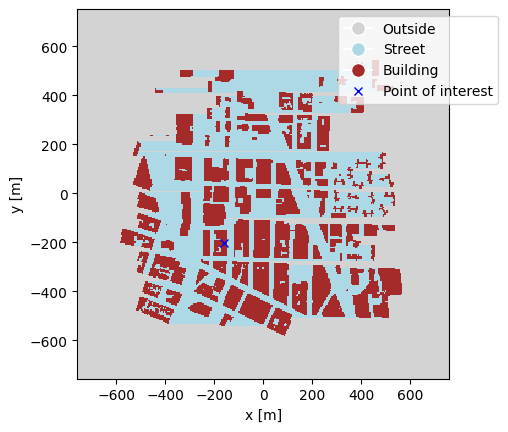

In [28]:
# Plot the grid
extent = extent=[cm.x[0], cm.x[-1], cm.y[0], cm.y[-1]]
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)

# PLot the point of interest
h, = plt.plot(xp, yp, 'bx')

# Create a legend for the manually created entries
legend_labels = ['Outside', 'Street', 'Building']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

# Add the point of interest
handles.append(h)
legend_labels.append('Point of interest')

plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))

# Add titles and labels
_ = plt.xlabel('x [m]')
_ = plt.ylabel('y [m]')


## Creating Your Own 3D Model

In some cases, you may want to create your own model.  I have created a simple wrapper function around the `geo2sigmap` function for this purpose.  The example code below gets a map around the empire state building in NYC.

In [30]:
from sionnautils.custom_scene import generate_scene

# Fill in the paramters here
address = '20 W 34th St., New York, NY 10001'
dir_name = 'herald_sq_nyc'  # Directory name
size_x = 1000  # bounding box size in meters
size_y = 1000
descr = 'Area around Empire State Building'

# Set a directory for the data
data_dir = os.path.join(os.getcwd(), dir_name)
generate_scene(address, data_dir=data_dir,
               size_x =size_x, size_y=size_y,
               descr=descr)

Running command: scenegen  bbox -73.991240 40.744157 -73.979369 40.753150 --data-dir C:\Users\sdran\Dropbox\srangan\academic\courses\Wireless\wirelesscomm\docs\geodemo\herald_sq_nyc


You can now view the scene as before.  The tall building is the Empire State Building.  YOu can see that it is simplified as a square box.  This is a problem in Open Street View that supplies the data.

In [31]:
scene_path = os.path.join(data_dir, 'scene.xml')
scene = sionna.rt.load_scene(scene_path)
# Render scene
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=512);

In [32]:
%%skip_if no_preview
# Open 3D preview (only works in Jupyter notebook)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

We can also print the meta data for the scene.

In [34]:
# Get the map data
import json
map_data_fn = os.path.join(data_dir, 'map_data.json')
if os.path.exists(map_data_fn):
    with open(map_data_fn, 'r') as f:
        map_data = json.load(f)
else:
    raise ValueError('Map data file %s does not exist' % map_data_fn)

# Print the map data
for k, v in map_data.items():
    print(f'{k}: {v}')

bbox_lat: [40.74415720447041, 40.75315042052959]
bbox_long: [-73.99123979934511, -73.97936882565487]
address: 20 W 34th St., New York, NY 10001
descr: Area around Empire State Building
